This notebook demonstrates clustering analysis on YouTube watch history data to identify patterns in watch times and visualize clusters.

# Setup Data

I load the YouTube watch history data from a JSON file into a pandas DataFrame (via Google Drive)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/COLAB/YOUTUBE/takeout-20240513T005827Z-001.zip -d ./data

Archive:  /content/drive/MyDrive/COLAB/YOUTUBE/takeout-20240513T005827Z-001.zip
  inflating: ./data/Takeout/YouTube and YouTube Music/history/search-history.json  
  inflating: ./data/Takeout/YouTube and YouTube Music/history/watch-history.json  
  inflating: ./data/Takeout/archive_browser.html  


In [ ]:
import json

file = "/content/data/Takeout/YouTube and YouTube Music/history/watch-history.json"
with open(file, 'r') as f:
    data = json.load(f)

print(len(data))
print(data[:5])

40800
[{'header': 'YouTube', 'title': "Watched The perfect imperfection of Google's Material You", 'titleUrl': 'https://www.youtube.com/watch?v=k7pks7yqQOc', 'subtitles': [{'name': 'David Imel', 'url': 'https://www.youtube.com/channel/UCtWpk3VvhcusiTBAYU5l5ZA'}], 'time': '2024-05-12T22:28:47.743Z', 'products': ['YouTube'], 'activityControls': ['YouTube watch history']}, {'header': 'YouTube', 'title': 'Watched Belajar dari KEGAGALAN Sepatu BATA', 'titleUrl': 'https://www.youtube.com/watch?v=S1VcNFfrwjw', 'subtitles': [{'name': 'Raymond Chin', 'url': 'https://www.youtube.com/channel/UCm4eA46c6boHmPrD0Lp2iEg'}], 'time': '2024-05-12T17:08:22.056Z', 'products': ['YouTube'], 'activityControls': ['YouTube watch history']}, {'header': 'YouTube', 'title': 'Watched Misteri Terus Berlanjut - Garten Of Banban 7 Indonesia Part 2', 'titleUrl': 'https://www.youtube.com/watch?v=wjje-e2seJg', 'subtitles': [{'name': 'MiawAug', 'url': 'https://www.youtube.com/channel/UC3J4Q1grz46bdJ7NJLd4DGw'}], 'time': 

In [ ]:
import pandas as pd
from datetime import datetime

def parse_time(time_str):
    for fmt in ('%Y-%m-%dT%H:%M:%SZ', '%Y-%m-%dT%H:%M:%S.%fZ'):
        try:
            return datetime.strptime(time_str, fmt)
        except ValueError:
            continue
    raise ValueError('no valid date format found')

watch_history = []
for item in data:
    if 'title' in item and 'time' in item:
        try:
            watch_time = parse_time(item['time'])
            watch_history.append({
                'year' : watch_time.year,
                'month': watch_time.month,
                'day': watch_time.day,
                'day_of_week': watch_time.weekday(),
                'hour_of_day': watch_time.hour,
                'watch_time': 1
            })
        except ValueError as e:
            print(f"Skipping item due to time format issue: {item['time']}")

df = pd.DataFrame(watch_history)
df.head(5)

,year,month,day,day_of_week,hour_of_day,watch_time
0,2024,5,12,6,22,1
1,2024,5,12,6,17,1
2,2024,5,12,6,16,1
3,2024,5,12,6,16,1
4,2024,5,12,6,16,1


In [ ]:
rows, columns = df.shape
print(rows, columns)

40800 6


In [ ]:
df['video_count'] = df.groupby(['year', 'month', 'day', 'day_of_week', 'hour_of_day'])['watch_time'].transform('sum')
df = df.drop_duplicates(subset=['year', 'month', 'day', 'day_of_week', 'hour_of_day'])
df = df.drop('watch_time', axis=1)
df.head(5)

,year,month,day,day_of_week,hour_of_day,video_count
0,2024,5,12,6,22,1
1,2024,5,12,6,17,1
2,2024,5,12,6,16,10
12,2024,5,12,6,15,6
18,2024,5,12,6,14,1


In [ ]:
rows, columns = df.shape
print(rows, columns)

4405 6


# Simple Plot Analizing

This simpe heatmap helps to find out pattern and analize for the clustering of watch times across different parameters.

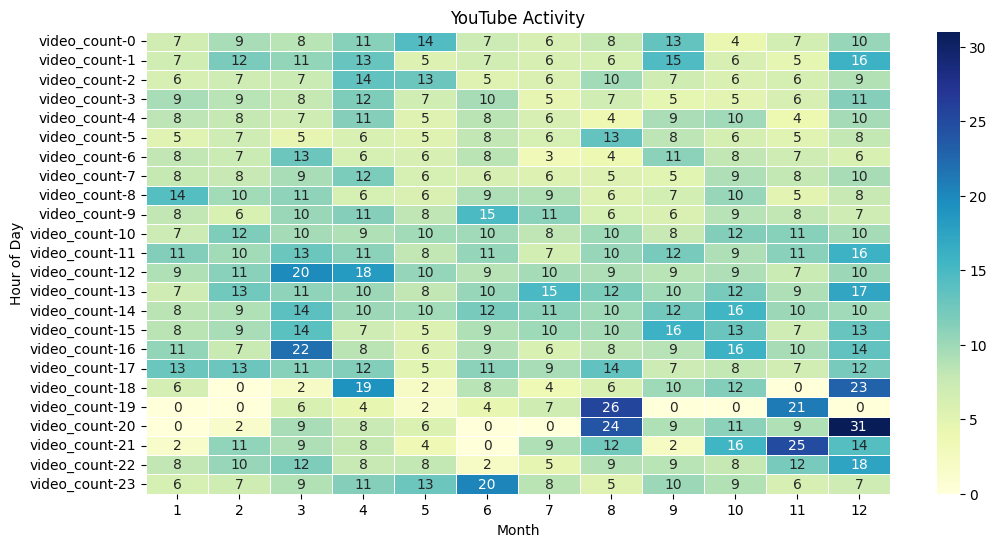

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df_heatmap = df.groupby(['month', 'hour_of_day']).agg({'video_count': 'mean'}).unstack().fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(df_heatmap.T, cmap="YlGnBu", annot=True, fmt='.0f', linewidths=0.5)
plt.title("YouTube Activity")
plt.xlabel('Month')
plt.ylabel('Hour of Day')
plt.show()


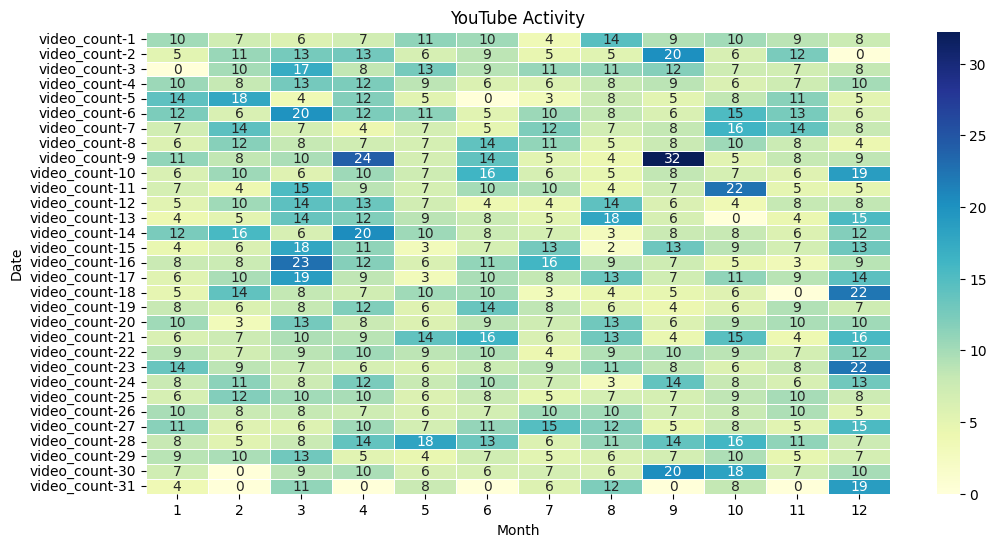

In [ ]:
df_heatmap = df.groupby(['month', 'day']).agg({'video_count': 'mean'}).unstack().fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(df_heatmap.T, cmap="YlGnBu", annot=True, fmt='.0f', linewidths=0.5)
plt.title("YouTube Activity")
plt.xlabel('Month')
plt.ylabel('Date')
plt.show()

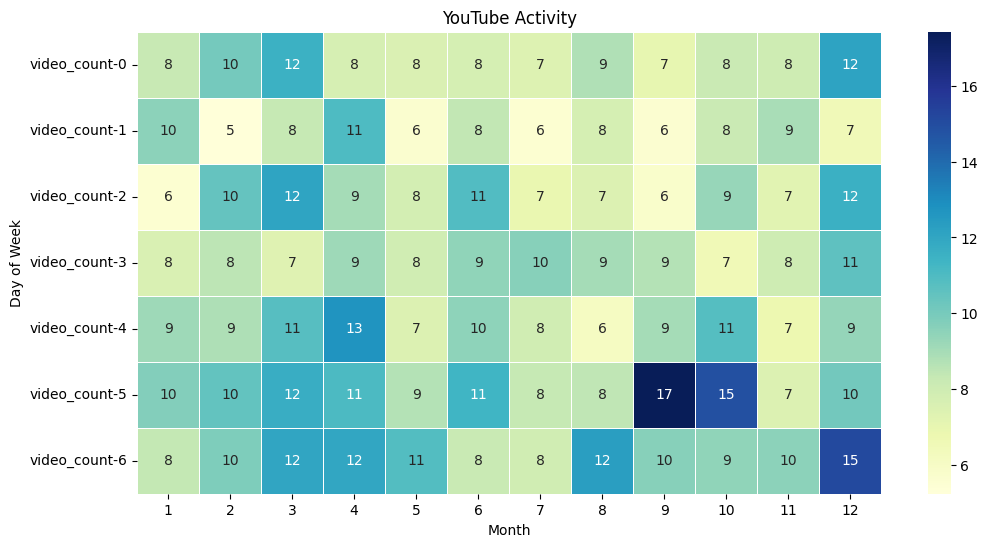

In [ ]:
df_heatmap = df.groupby(['month', 'day_of_week']).agg({'video_count': 'mean'}).unstack().fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(df_heatmap.T, cmap="YlGnBu", annot=True, fmt='.0f', linewidths=0.5)
plt.title("YouTube Activity")
plt.xlabel('Month')
plt.ylabel('Day of Week')
plt.show()

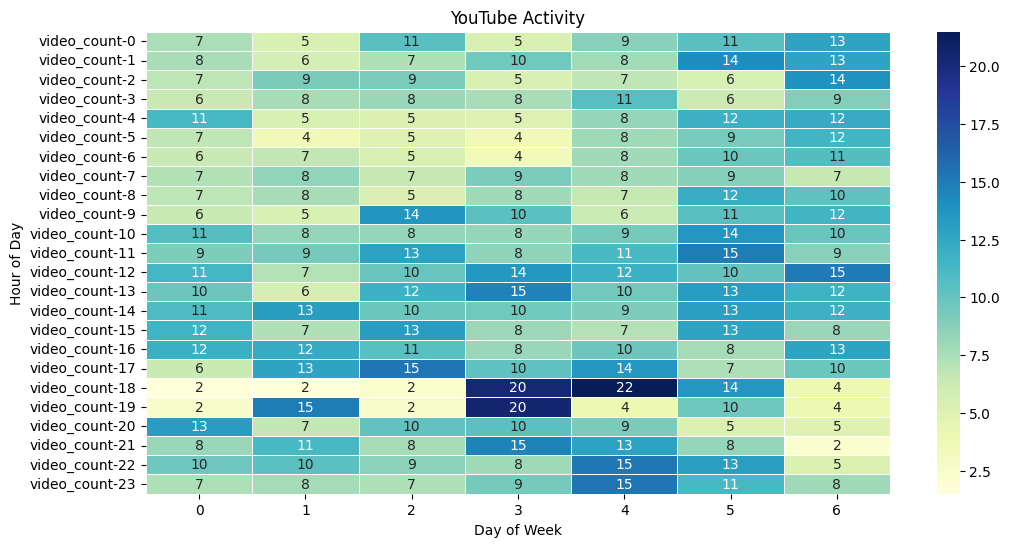

In [ ]:
df_heatmap = df.groupby(['day_of_week', 'hour_of_day']).agg({'video_count': 'mean'}).unstack().fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(df_heatmap.T, cmap="YlGnBu", annot=True, fmt='.0f', linewidths=0.5)
plt.title("YouTube Activity")
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.show()

# Preprocess Data

I preprocess the data by extracting relevant features such as the day of the week and the hour of the day from the timestamp.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4405 entries, 0 to 40789
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   year         4405 non-null   int64
 1   month        4405 non-null   int64
 2   day          4405 non-null   int64
 3   day_of_week  4405 non-null   int64
 4   hour_of_day  4405 non-null   int64
 5   video_count  4405 non-null   int64
dtypes: int64(6)
memory usage: 240.9 KB


## Drop Year and Day

In [ ]:
df = df.drop(['year', 'day'], axis=1)
df.head()

,month,day_of_week,hour_of_day,video_count
0,5,6,22,1
1,5,6,17,1
2,5,6,16,10
12,5,6,15,6
18,5,6,14,1


In [ ]:
df_day_hour_count = df.groupby(['day_of_week', 'hour_of_day']).agg({'video_count': 'mean'}).reset_index()
df_day_hour_count['video_count'] = df_day_hour_count['video_count'].astype(int)
df_day_hour_count.head()

,day_of_week,hour_of_day,video_count
0,0,0,7
1,0,1,7
2,0,2,6
3,0,3,6
4,0,4,11


# Clustering

I apply K-means clustering to identify patterns in the watch times.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

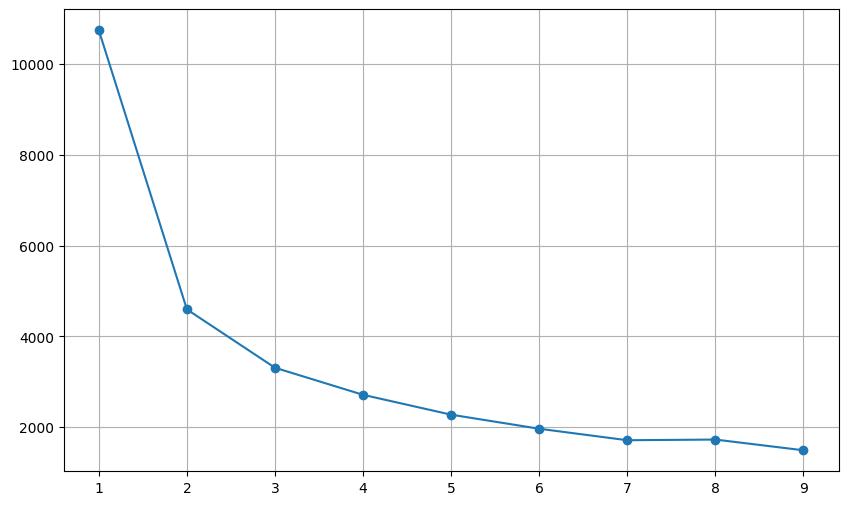

In [ ]:
model_1  = SimpleImputer(strategy='mean').fit_transform(df_day_hour_count)

inertia_values = []
clusters = range(1, 10)

for i in clusters:
  km = KMeans(n_clusters=i, random_state=42).fit(model_1)
  inertia_values.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(clusters, inertia_values, marker='o')
plt.grid(True)
plt.show()

In [ ]:
km3 = KMeans(n_clusters=2).fit(model_1)
df_day_hour_count['cluster'] = km3.labels_
df_day_hour_count.head()

,day_of_week,hour_of_day,video_count,cluster
0,0,0,7,1
1,0,1,7,1
2,0,2,6,1
3,0,3,6,1
4,0,4,11,1


I visualize the clusters to interpret the patterns in watch times. This scatter plot helps to visualize the clustering of watch times across different hours of the day.

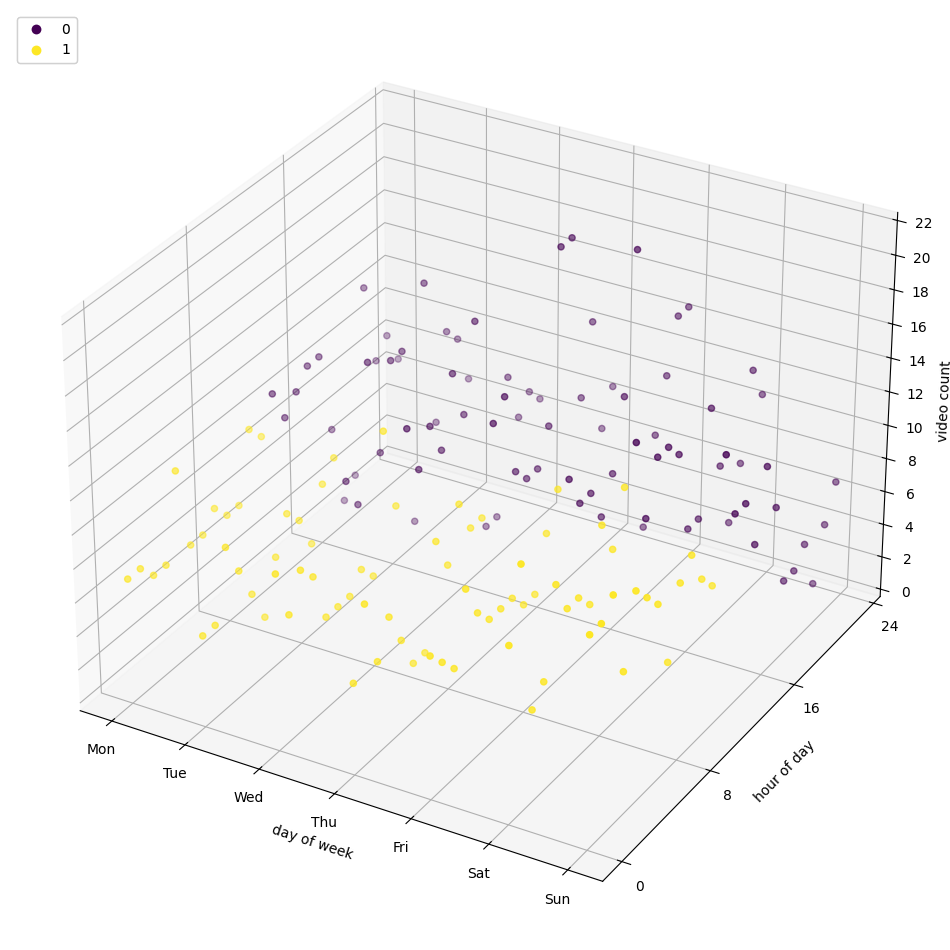

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
fig = plt.figure(figsize=(12, 15))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('day of week')
ax.set_xticks(np.arange(0, 7, 1))
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

ax.set_ylabel('hour of day')
ax.set_yticks(np.arange(0, 25, 8))
ax.set_yticklabels(np.arange(0, 25, 8))

ax.set_zlabel('video count')
ax.set_zticks(np.arange(0, 25, 2))
ax.set_zticklabels(np.arange(0, 25, 2))


scatter = ax.scatter(xs=df_day_hour_count['day_of_week'],
                     ys=df_day_hour_count['hour_of_day'],
                     zs=df_day_hour_count['video_count'],
                     c=df_day_hour_count['cluster'])
legend = ax.legend(*scatter.legend_elements(), loc='upper left')
ax.add_artist(legend)
plt.show()

I calculate the silhouette coefficient to evaluate the quality of the clustering. The silhouette coefficient ranges from -1 to 1, where a higher score indicates better-defined clusters.

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
X = df_day_hour_count[['day_of_week' ,'hour_of_day', 'video_count']].values
cluster_labels = df_day_hour_count['cluster'].values

silhouette_avg = silhouette_score(X, cluster_labels)
sample_silhouette_values = silhouette_samples(X, cluster_labels)
print(f"Average silhouette score: {silhouette_avg:0.1f}")

Average silhouette score: 0.5
